In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import h5py
import pandas as pd
import seaborn as sns
import ringdown as rd
import ringdown
import pyRing.waveform

sns.set(context='notebook', palette='colorblind')

/work/yifan.wang/virtualenv/ringdown/lib/python3.7/site-packages/pyRing/utils.py:16: UserWarning: surfinBH is not automatically installed due to possible conflicts. If you wish to use its functionalities, it needs to be installed separately.
  warnings.warn("surfinBH is not automatically installed due to possible conflicts. If you wish to use its functionalities, it needs to be installed separately.")


In [3]:
def read_strain(file, dname):
    with h5py.File(file, 'r') as f:
        t0 = f['meta/GPSstart'][()]
        T = f['meta/Duration'][()]
        h = f['strain/Strain'][:]
    
        dt = T/len(h)
    
        raw_strain = ringdown.Data(h, index=t0 + dt*arange(len(h)), ifo=dname)
        
        return raw_strain

ifos = ['H1', 'L1']
input_path = '{i}-{i}1_GWOSC_16KHZ_R1-1126257415-4096.hdf5'
raw_strain = {i: read_strain(input_path.format(i=i[0]), i) for i in ifos}

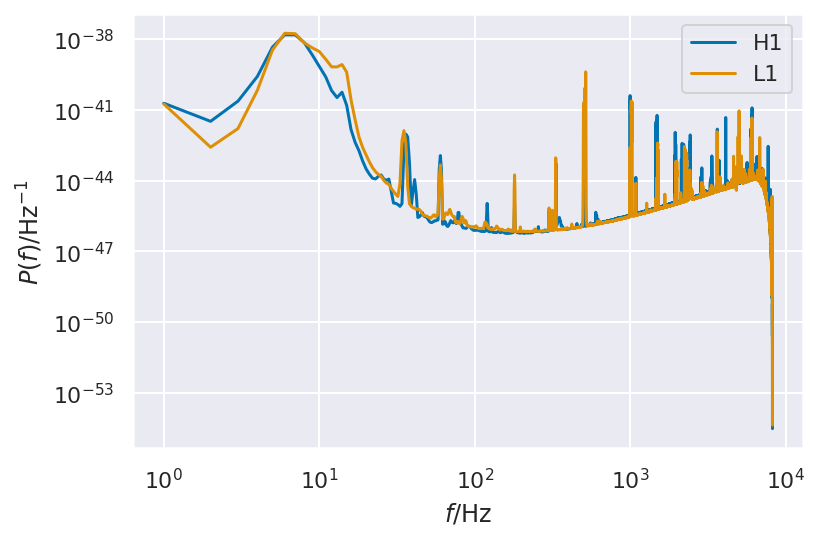

In [4]:
for i, s in raw_strain.items():
    s.get_psd(nperseg=int(s.fsamp)).iloc[1:].plot(label=i)
xlabel(r'$f / \mathrm{Hz}$');
ylabel(r'$P\left( f \right) / \mathrm{Hz}^{-1}$');
xscale('log');
yscale('log');
legend(loc='best');

In [5]:
T = 0.2
srate = 4096

M_est = 70.0
chi_est = 0.7

longest_tau = rd.qnms.get_ftau(M_est, chi_est, 0, l=2, m=2)[1]
highest_drate = 1/rd.qnms.get_ftau(M_est, chi_est, 1, l=2, m=2)[1]
print('The damping rate of the second tone is: {:.1f} Hz'.format(highest_drate))
print('The time constant of the first tone is: {:.1f} ms'.format(1000*longest_tau))

print('Segment of {:.1f} ms at sample rate {:.0f}'.format(1000*T, srate))

The damping rate of the second tone is: 708.4 Hz
The time constant of the first tone is: 4.3 ms
Segment of 200.0 ms at sample rate 4096


In [6]:
fit = ringdown.Fit(model='mchi_aligned')

# specify we want two-tones (n=0,1), by default with `s=-2, l=2, m=2, p=1`
fit.set_tone_sequence(2)

# add data
for s in raw_strain.values():
    fit.add_data(s)

# set analysis target, offset by `dt0` seconds from the reference time in Isi et al (2019).
dt0M = 0
Mref = 69
dt0 = dt0M*Mref*ringdown.qnms.T_MSUN

fit.set_target(1126259462.4083147 + dt0, ra=1.95, dec=-1.27, psi=0.82, duration=T)

Having set the target, we can now condition the data. The `Fit` object will know to preserve the sample closest to the targeted truncation time, even after downsampling.

In [7]:
# condition data
fit.condition_data(ds=int(round(raw_strain[ifos[0]].fsamp/srate)), flow=20)

In [8]:
# compute autocovariance functions
fit.compute_acfs()

In [9]:
fit.acfs

{'H1': 0.000000    2.437019e-40
 0.000244   -1.363961e-41
 0.000488   -2.051204e-40
 0.000732    1.066530e-41
 0.000977    1.630322e-40
                 ...     
 0.998779    5.765249e-41
 0.999023    1.630322e-40
 0.999268    1.066530e-41
 0.999512   -2.051204e-40
 0.999756   -1.363961e-41
 Length: 4096, dtype: float64,
 'L1': 0.000000    1.038628e-39
 0.000244    6.484791e-40
 0.000488   -1.169986e-40
 0.000732   -6.405975e-40
 0.000977   -7.815737e-40
                 ...     
 0.998779   -6.205008e-40
 0.999023   -7.815737e-40
 0.999268   -6.405975e-40
 0.999512   -1.169986e-40
 0.999756    6.484791e-40
 Length: 4096, dtype: float64}

In [10]:
fit.acfs['H1'].index.values

array([0.00000000e+00, 2.44140625e-04, 4.88281250e-04, ...,
       9.99267578e-01, 9.99511719e-01, 9.99755859e-01])

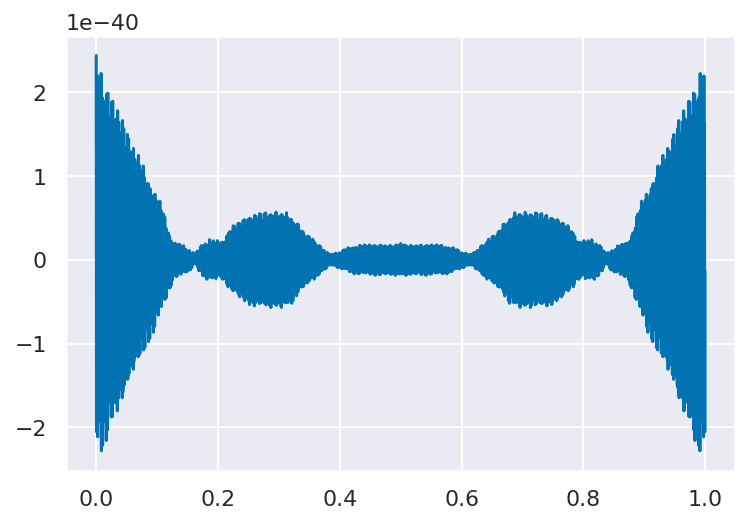

In [11]:
plt.plot(fit.acfs['H1'].index.values,fit.acfs['H1'].values)

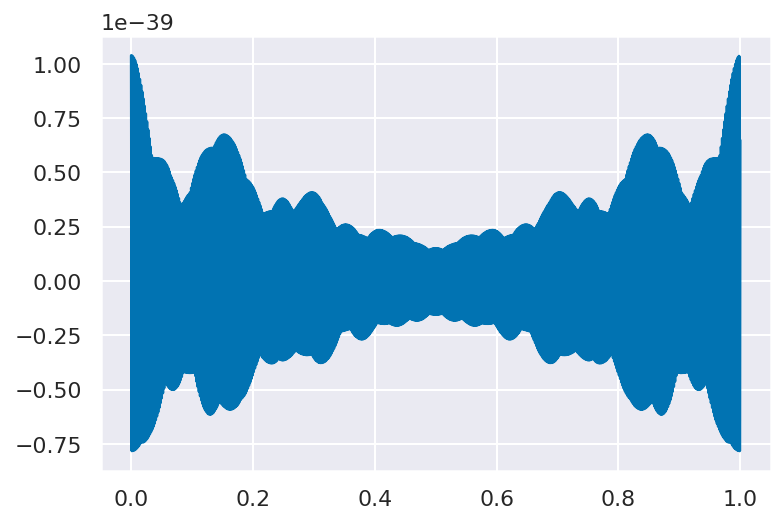

In [12]:
plt.plot(fit.acfs['L1'].index.values,fit.acfs['L1'].values)

In [13]:
np.savetxt('/work/yifan.wang/devringdown/H1-acf.txt',
           np.transpose([fit.acfs['H1'].index.values,fit.acfs['H1'].values]))

In [14]:
np.savetxt('/work/yifan.wang/devringdown/L1-acf.txt',
           np.transpose([fit.acfs['L1'].index.values,fit.acfs['L1'].values]))

It is instructive to look at the whitened data segment in both interferometers:

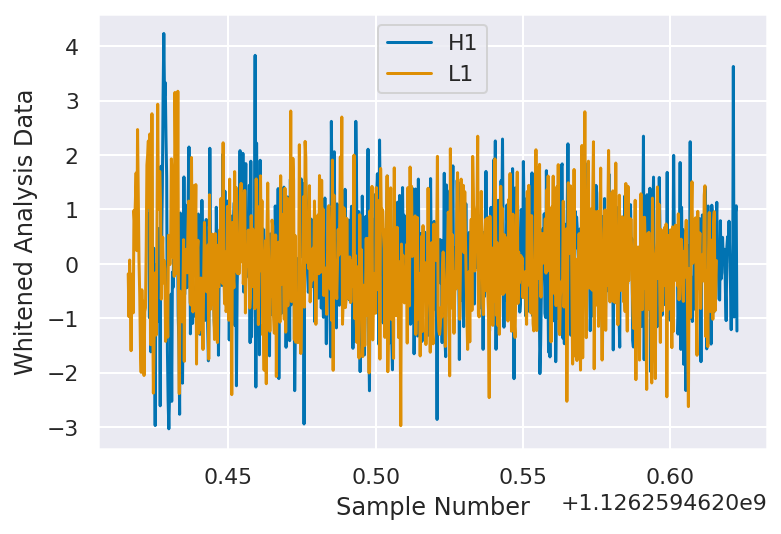

In [15]:
wd = fit.whiten(fit.analysis_data)
plot(wd['H1'], label='H1')
plot(wd['L1'], label='L1')
legend(loc='best');
xlabel(r'Sample Number');
ylabel(r'Whitened Analysis Data');

Just for a sanity check, let's look at the time of arrival of the peak strain in each IFO (Isi, et al. (2019) actually gives the `H1` start time, not the geocentre time, as `1126259462.423`):

In [16]:
fit.start_times

{'H1': 1126259462.423, 'L1': 1126259462.4160156}

In [17]:
fit.antenna_patterns

{'H1': [0.578742411175002, -0.4509478210953121],
 'L1': [-0.5274334329518102, 0.20520960891727436]}

In [18]:
fit.update_prior(A_scale=5e-21, M_min=35.0, M_max=140.0, cosi_max=-0.99, flat_A=1)

In [19]:
fit.prior_settings

{'A_scale': 5e-21,
 'drift_scale': 0.0,
 'perturb_f': array([0., 0.]),
 'perturb_tau': array([0., 0.]),
 'df_max': 0.5,
 'dtau_max': 0.5,
 'M_min': 35.0,
 'M_max': 140.0,
 'chi_min': 0,
 'chi_max': 0.99,
 'cosi_min': -1,
 'cosi_max': -0.99,
 'flat_A': 1}

In [20]:
fit.model_input

{'nsamp': 819,
 'nmode': 2,
 'nobs': 2,
 't0': [1126259462.423, 1126259462.4160156],
 'times': [Float64Index([1126259462.4229736, 1126259462.4232178,  1126259462.423462,
                 1126259462.423706, 1126259462.4239502, 1126259462.4241943,
                1126259462.4244385, 1126259462.4246826, 1126259462.4249268,
                 1126259462.425171,
                ...
                1126259462.6204834, 1126259462.6207275, 1126259462.6209717,
                1126259462.6212158,   1126259462.62146,  1126259462.621704,
                1126259462.6219482, 1126259462.6221924, 1126259462.6224365,
                1126259462.6226807],
               dtype='float64', length=819),
  Float64Index([1126259462.4160156, 1126259462.4162598,  1126259462.416504,
                 1126259462.416748, 1126259462.4169922, 1126259462.4172363,
                1126259462.4174805, 1126259462.4177246, 1126259462.4179688,
                 1126259462.418213,
                ...
                1126259462.6

In [21]:
stan_data = fit.model_input

In [22]:
stan_data['only_prior']=0

In [23]:
par = fit._model.optimizing(data=stan_data)

Initial log joint probability = 78128.3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       79265.9     0.0943691       15.1809           1           1       25   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       79269.6     0.0511333       2.38176           1           1       48   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      49       79269.8    0.00287345      0.291394           1           1       58   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [24]:
par

OrderedDict([('log_drift_unit', array([0.00886328, 0.003861  ])),
             ('M', array(82.24456687)),
             ('chi', array(0.84643986)),
             ('cosi', array(-0.99767041)),
             ('iota_unit', array([-0.90908777,  0.41660465])),
             ('Ax_unit', array([0.14032668, 0.06600085])),
             ('Ay_unit', array([ 0.23033894, -0.23333657])),
             ('dts', array(1.56918588e-07)),
             ('df', array([ 0.03690055, -0.27401155])),
             ('dtau', array([-0.36273071, -0.0476305 ])),
             ('drift', array([1., 1.])),
             ('gamma', array([177.0905584 , 533.56848594])),
             ('f', array([243.4362405, 240.9471197])),
             ('h_det_mode',
              array([[[-3.06666285e-22,  4.11214281e-22,  1.01461040e-21, ...,
                        1.63379226e-37, -1.79661159e-37, -4.70247799e-37],
                      [ 1.49271318e-21,  9.02780027e-22,  3.27646511e-22, ...,
                        1.01776328e-67,  6.1202443

In [25]:
par['h_det']

array([[ 1.18604689e-21,  1.31399431e-21,  1.34225691e-21, ...,
         1.63379226e-37, -1.79661159e-37, -4.70247799e-37],
       [-1.09180907e-21, -1.09060919e-21, -1.01640510e-21, ...,
         1.13720520e-37,  3.51886469e-37,  5.23243683e-37]])

(0.0, 50.0)

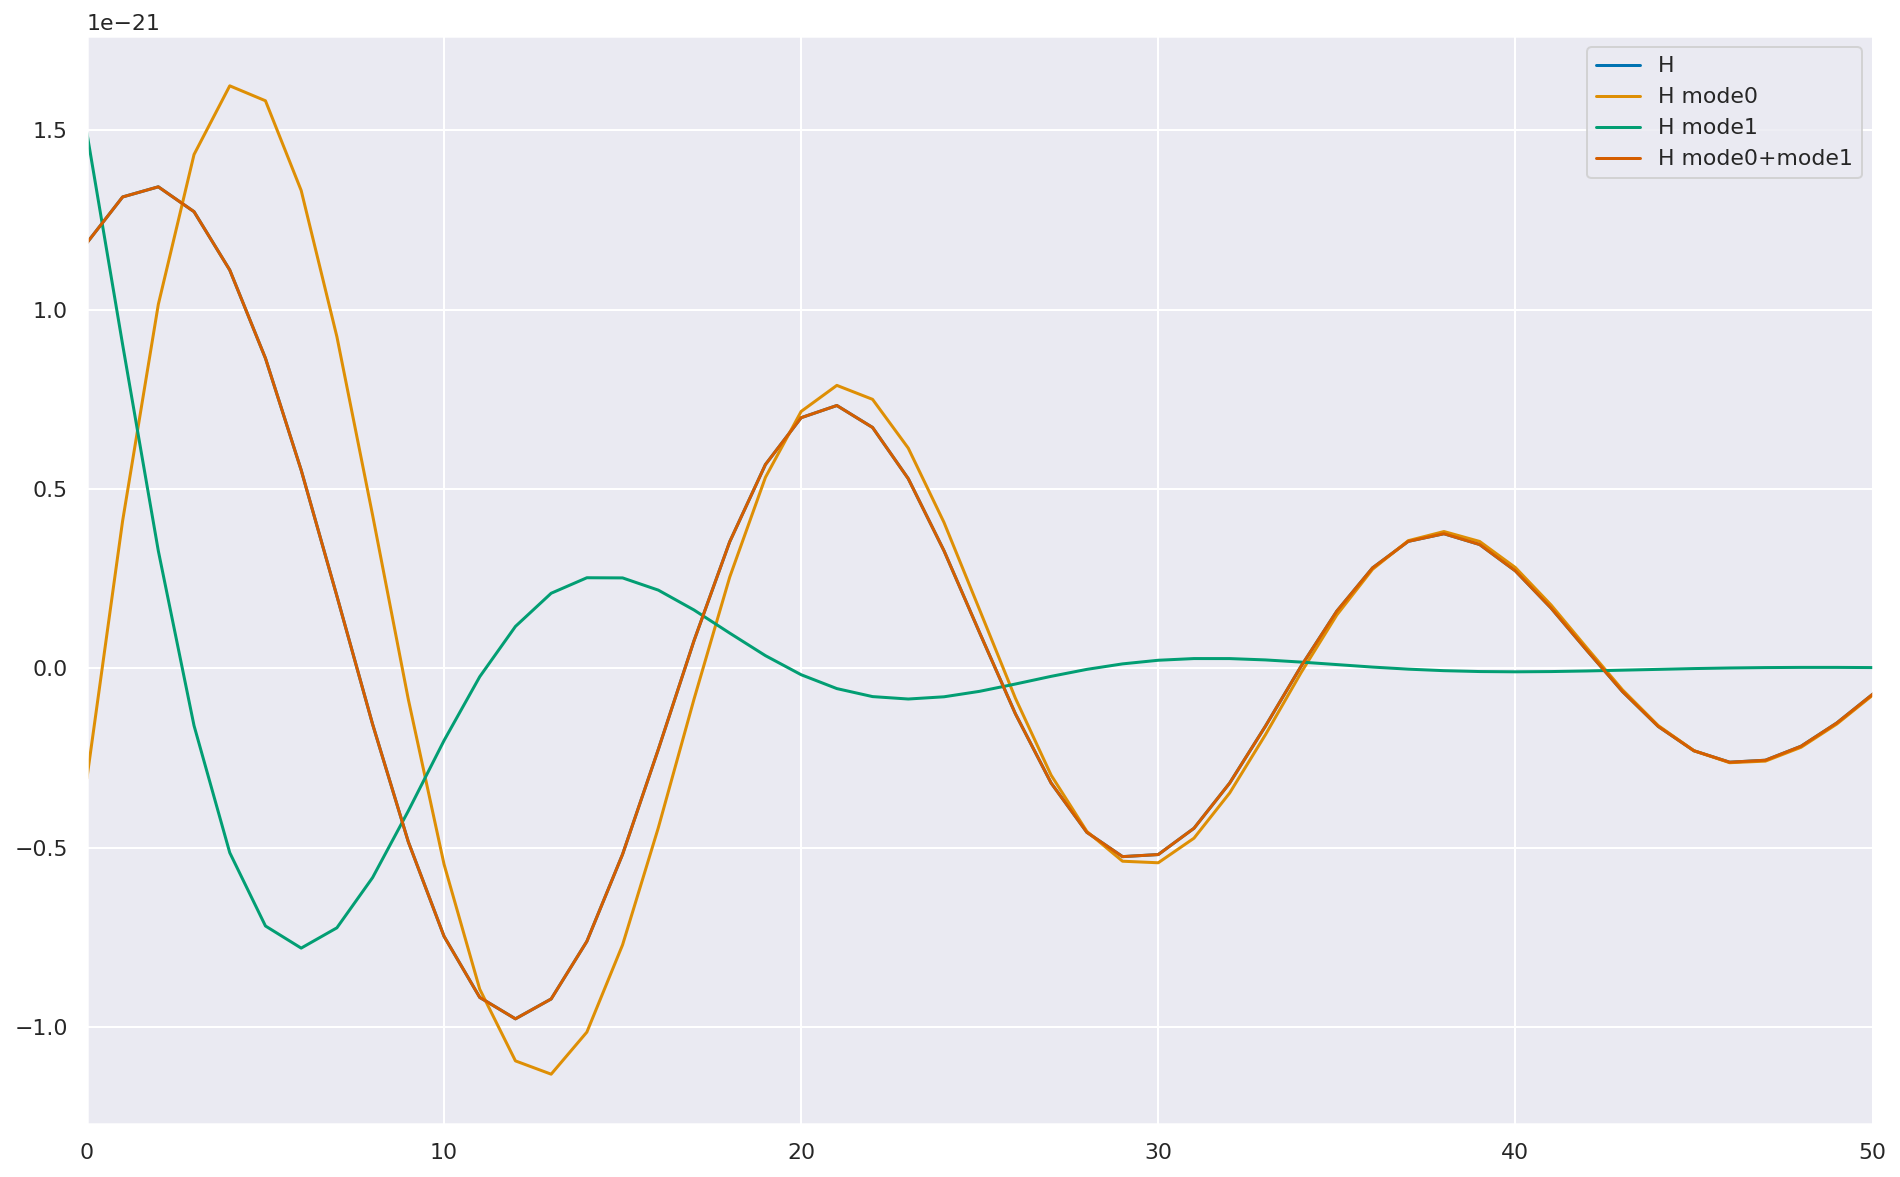

In [26]:
plt.figure(figsize=[16,10])
plt.plot(par['h_det'][0],label='H')
plt.plot(par['h_det_mode'][0][0],label='H mode0')
plt.plot(par['h_det_mode'][0][1],label='H mode1')
plt.plot(par['h_det_mode'][0][0]+par['h_det_mode'][0][1],label='H mode0+mode1')
plt.legend()
plt.xlim(0,50)

In [27]:
def rd(t, f, gamma, A, cosi, phi, Fp,Fc):
    phase = 2*np.pi*f*t - phi
    p = (1 + cosi**2)*A*np.exp(-gamma*t)*np.cos(phase)
    c = 2*cosi*A*np.exp(-gamma*t)*np.sin(phase)
    return Fp*p + Fc*c

def chi_factors(chi,nmode,coeffs):
    log1mc = np.log1p(-chi);

    for i in range(nmode):
        f[i] = c[1]*chi + c[2] + log1mc*(c[3] + log1mc*(c[4] + log1mc*(c[5] + log1mc*c[6])))
    return f

def h_det(nobs,nmode,M,chi,f_coeffs,g_coeffs):
    fref = 2985.668287014743
    mref = 68.0
    f0 = fref*mref/M
    f = f0*chi_factors(chi, nmode, f_coeffs)
    gamma = f0*chi_factors(chi, nmode, g_coeffs)
    
    h_det = 0
    h_det_model = {}
    for i in range(nobs):
        for j in range(nmode):
            h_det_mode = rd(times[i] - t0[i], f[j], gamma[j], A[j], cosi, phi[j], FpFc[i][0],FpFc[i][1]);
            h_det += h_det_mode
    return h_det

In [28]:
f = par['f']
gamma = par['gamma'] #gamma is just 1/tau
A = par['A']
phi = par['phi']
tau = par['tau']
cosi = par['cosi']
M = float(par['M'])
chi = float(par['chi'])
fpfc = stan_data['FpFc']
t0 = stan_data['t0']
times = stan_data['times']

## Check f and tau

In [29]:
ringdown.qnms.get_ftau(M,float(chi),0)

(243.47018441879672, 0.005645662375261224)

In [30]:
ringdown.qnms.get_ftau(M,float(chi),1)

(241.0051467913989, 0.0018732435509765718)

In [31]:
f

array([243.4362405, 240.9471197])

In [32]:
1/gamma

array([0.00564683, 0.00187417])

In [33]:
fit.modes

[ModeIndex(p=1, s=-2, l=2, m=2, n=0), ModeIndex(p=1, s=-2, l=2, m=2, n=1)]

In [34]:
rdkerr = ringdown.qnms.KerrMode(fit.modes[0])

In [35]:
rdkerr.ftau(chi,M,approx=False)

(243.47018441879672, 0.005645662375261224)

In [36]:
rdkerr.ftau(chi,M,approx=True)

(243.43624050261832, 0.005646828430718626)

# Run

In [ ]:
fit.run()


Gradient evaluation took 0.396686 seconds
1000 transitions using 10 leapfrog steps per transition would take 3966.86 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.379748 seconds
1000 transitions using 10 leapfrog steps per transition would take 3797.48 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.408568 seconds
1000 transitions using 10 leapfrog steps per transition would take 4085.68 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.472161 seconds
1000 transitions using 10 leapfrog steps per transition would take 4721.61 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)


In [ ]:
fit.result.to_netcdf('my_gw150914_0602_srate4096.nc')

### seems good. How about PyRing

In [31]:
qnm = pyRing.waveform.QNM_fit(2,2,0)
qnmn1 = pyRing.waveform.QNM_fit(2,2,1)

In [32]:
print(qnm.f(M,chi),qnmn1.f(M,chi))

230.0743668265259 228.28579278600768


In [33]:
print(qnm.tau(M,chi),qnmn1.tau(M,chi))

0.0064646182836434595 0.0021514305718728635


### Seems good. How about PyCBC?

In [34]:
conversions.get_lm_f0tau_allmodes(M,chi,['222'])

({'220': 231.5607186353572, '221': 229.7063859942767},
 {'220': 0.006427087160861681, '221': 0.002133784696121474})

In [35]:
yifan_h_han_mode0 = rd(times[0]-t0[0],
                      f[0],
                      gamma[0],
                      A[0],
                      cosi,
                      phi[0],
                      fpfc[0][0],
                      fpfc[0][1])

yifan_h_han_mode1 = rd(times[0]-t0[0],
                      f[1],
                      gamma[1],
                      A[1],
                      cosi,
                      phi[1],
                      fpfc[0][0],
                      fpfc[0][1])

(0.0, 50.0)

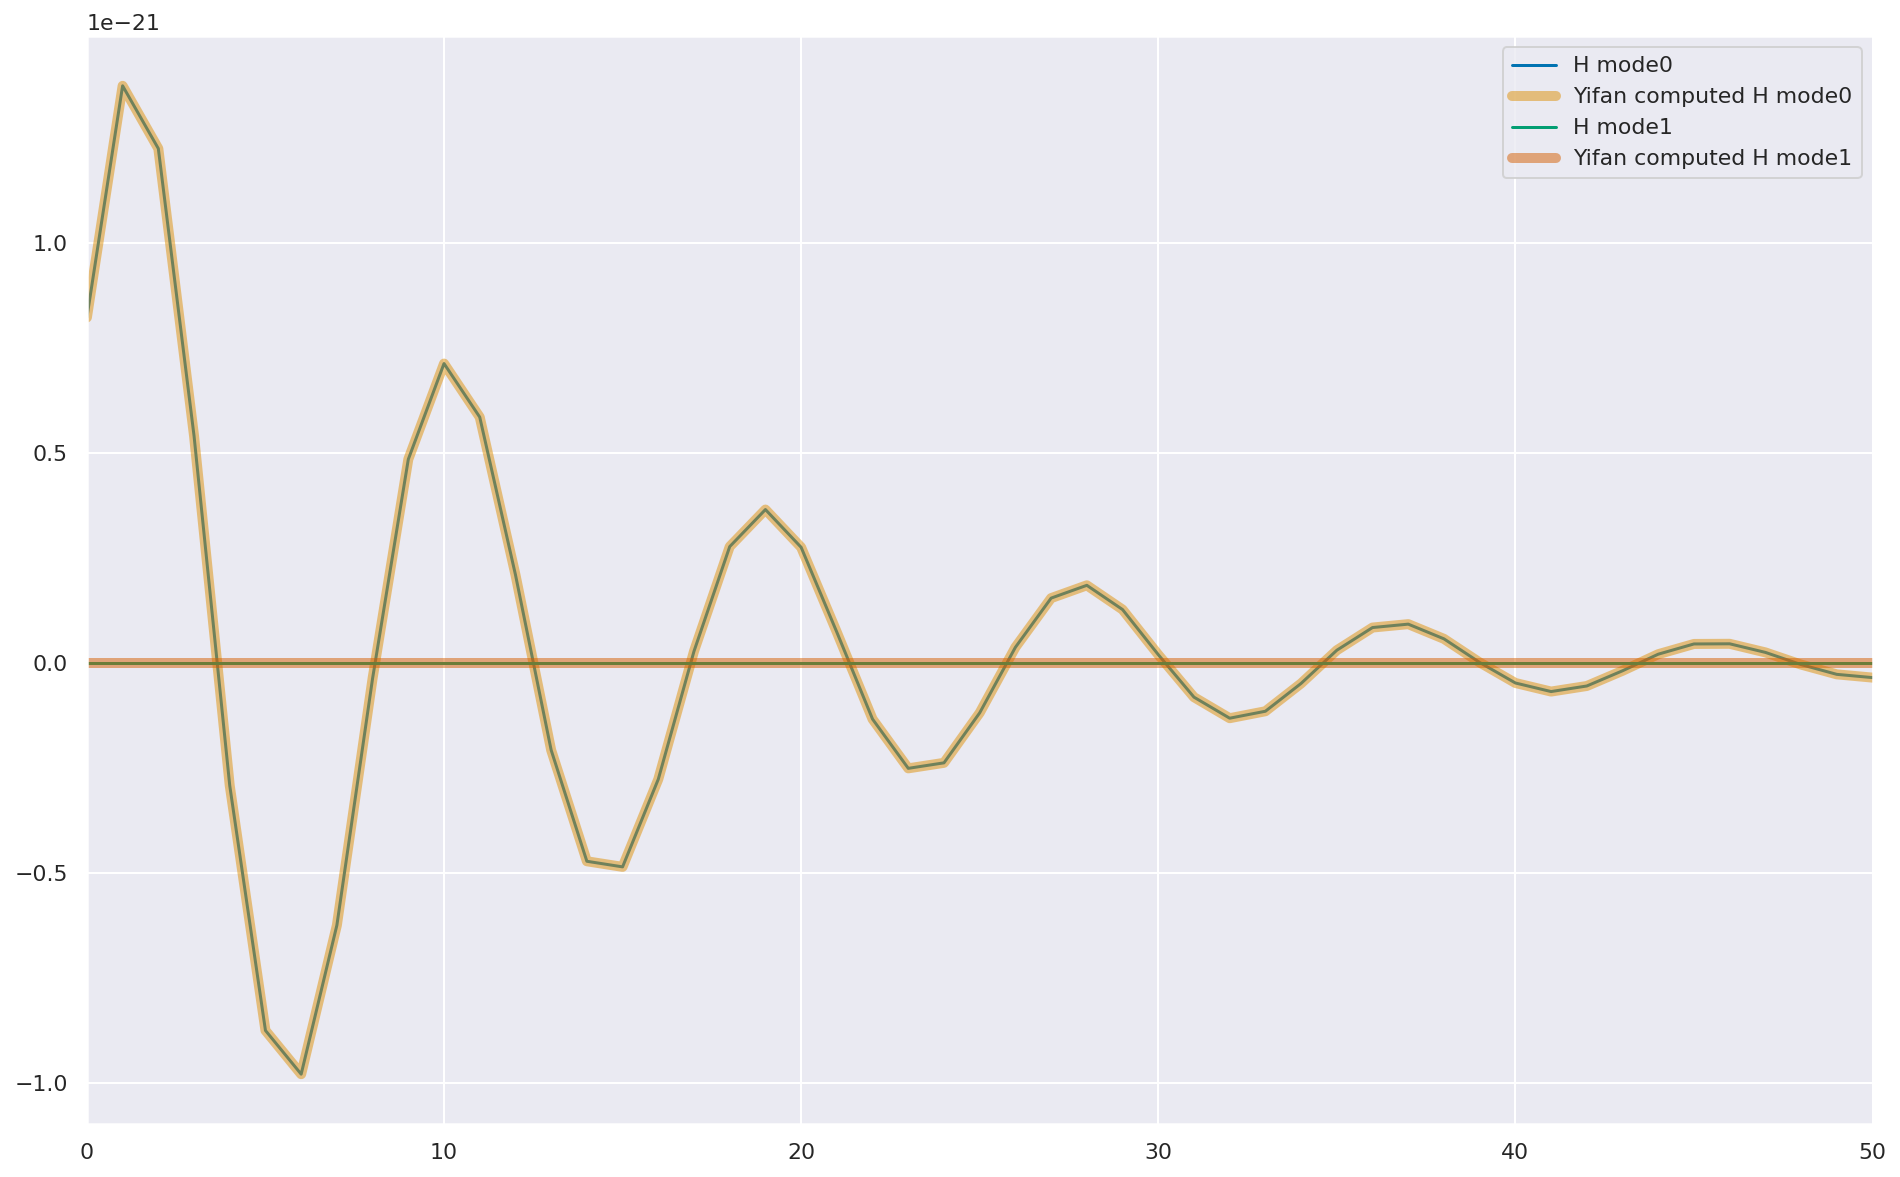

In [36]:
plt.figure(figsize=[16,10])
plt.plot(par['h_det_mode'][0][0],label='H mode0')
plt.plot(yifan_h_han_mode0,lw = 5,alpha=0.5,label='Yifan computed H mode0')
plt.plot(par['h_det_mode'][0][1],label='H mode1')
plt.plot(yifan_h_han_mode1,lw = 5,alpha=0.5,label='Yifan computed H mode1')
plt.legend()
plt.xlim(0,50)

# Read in the nc file (results of PyStan

In [12]:
result = az.from_netcdf('my_gw150914_fit.nc')

In [13]:
result

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'M'}>,
        <AxesSubplot:title={'center':'M'}>],
       [<AxesSubplot:title={'center':'chi'}>,
        <AxesSubplot:title={'center':'chi'}>]], dtype=object)

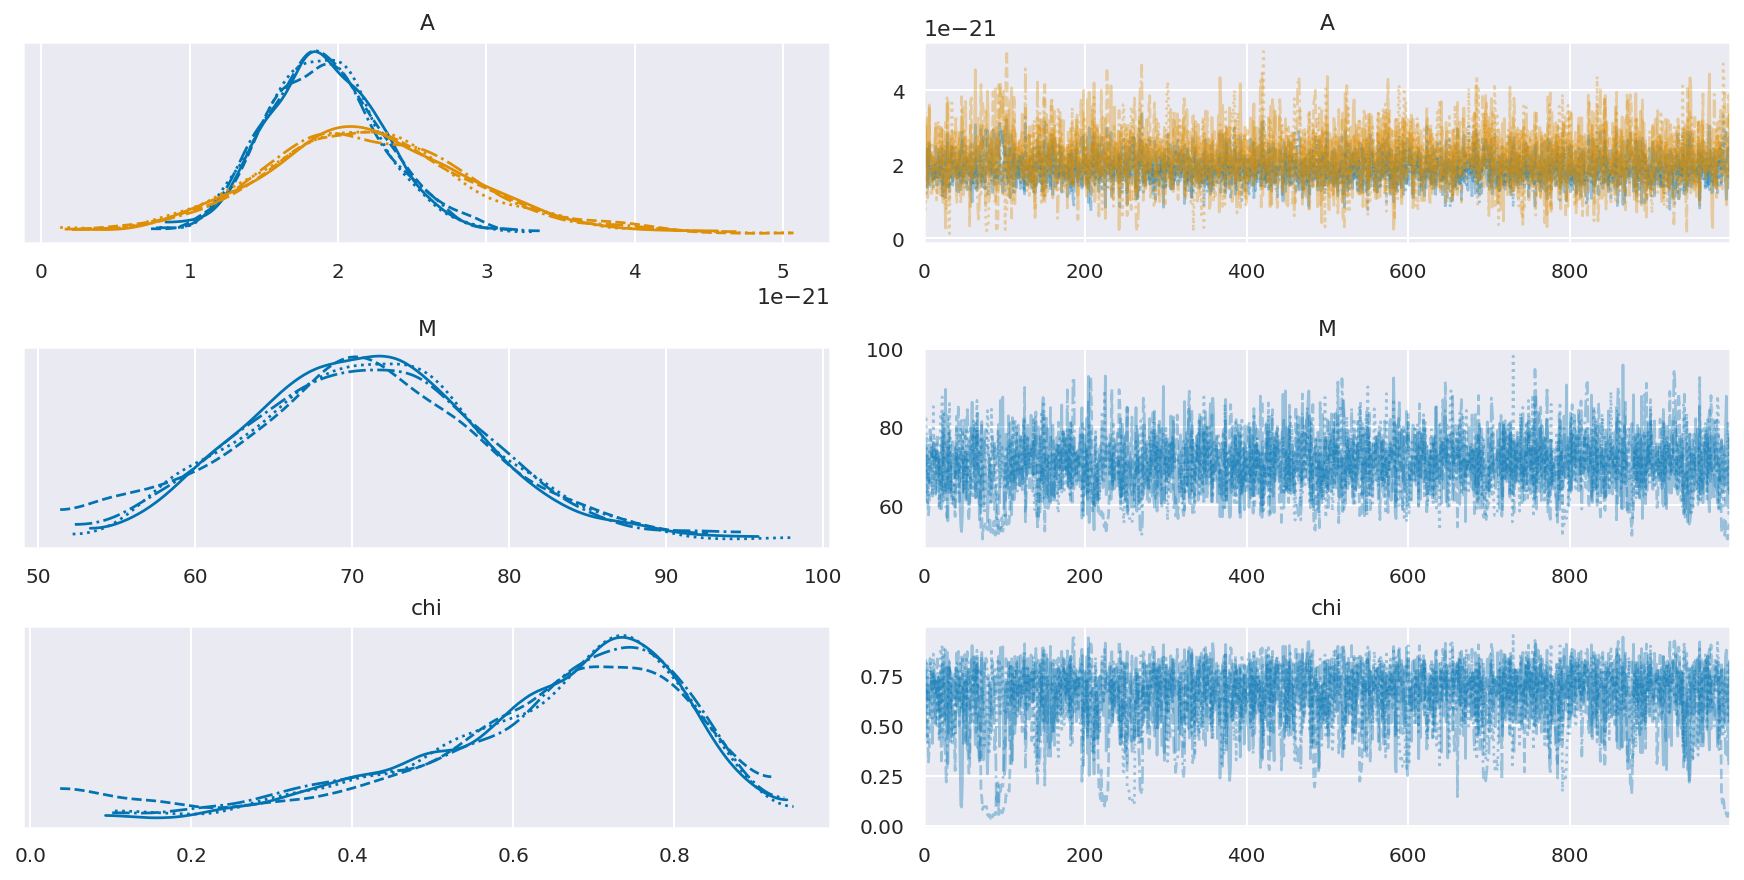

In [14]:
az.plot_trace(result, var_names=['A', 'M', 'chi'], compact=True)

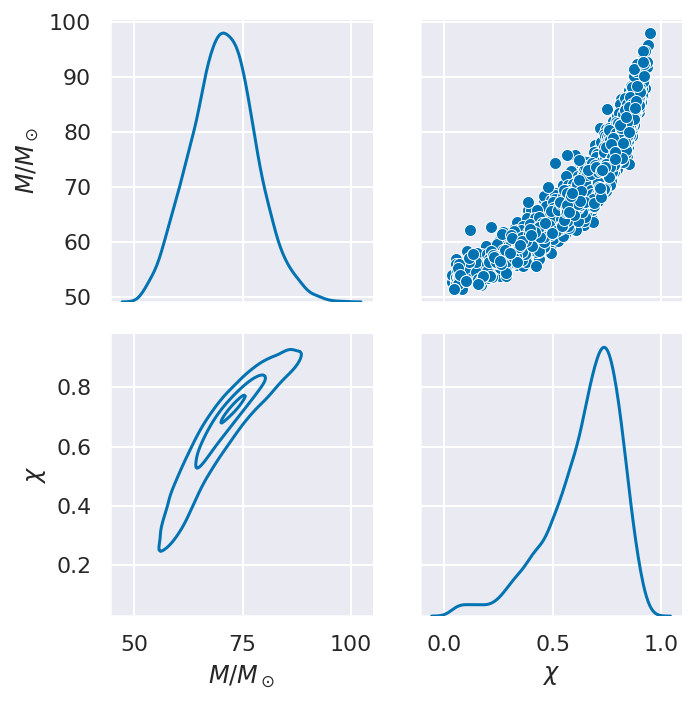

In [7]:
df = pd.DataFrame({
    r'$M / M_\odot$': result.posterior.M.values.flatten(),
    r'$\chi$': result.posterior.chi.values.flatten()
})
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot);
pg.map_upper(sns.scatterplot);
pg.map_lower(ringdown.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1]);

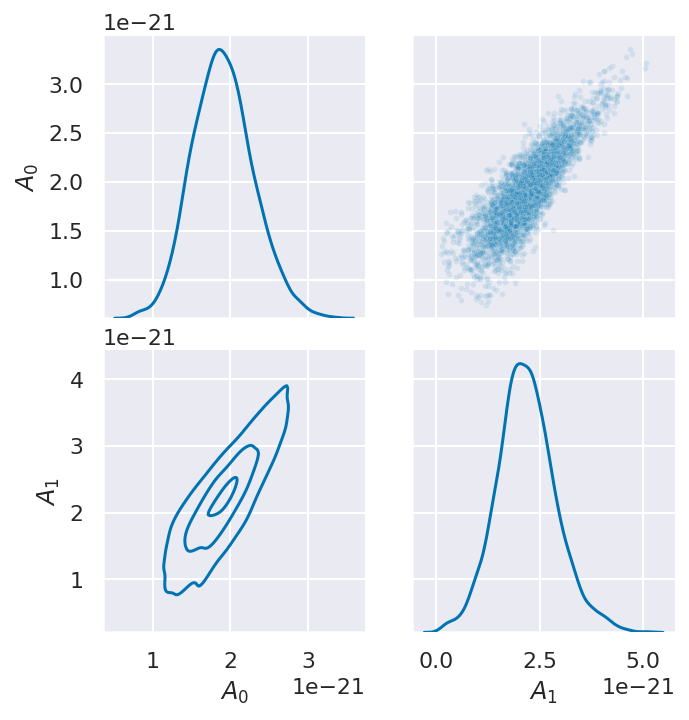

In [8]:
df = pd.DataFrame({
    r'$A_0$': result.posterior.A.values[:,:,0].flatten(),
    r'$A_1$': result.posterior.A.values[:,:,1].flatten()
})
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot);
pg.map_upper(sns.scatterplot, alpha=0.1, marker='.');
pg.map_lower(ringdown.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1]);

In [9]:
x = result.posterior.A.values[:,:,1].flatten()
mean(x) / std(x)

3.07067650143737

In [10]:
print('f0 = {:.2f} +-{:.2f}'.format(median(result.posterior.f[:,:,0]), std(result.posterior.f[:,:,0].values)))

f0 = 240.52 +-7.80


### Reconstructions

Get median signal reconstructions at each detector:

In [27]:
result

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [21]:
ms, mf, mo = {}, {}, {}

for i, ifo in enumerate(fit.ifos):
    # median reconstructed signal at each detector
    ms[ifo] = result.posterior.h_det.median(axis=(0,1)).values[i,:] 

    # median reconstructed fundamental mode at each detector
    mf[ifo] = result.posterior.h_det_mode.median(axis=(0,1)).values[i,0,:]

    # median reconstructed overtone at each detector
    mo[ifo] = result.posterior.h_det_mode.median(axis=(0,1)).values[i,1,:]

Here is a plot of the un-whitened (i.e. raw) ringdown signal, also decomposed into modes.

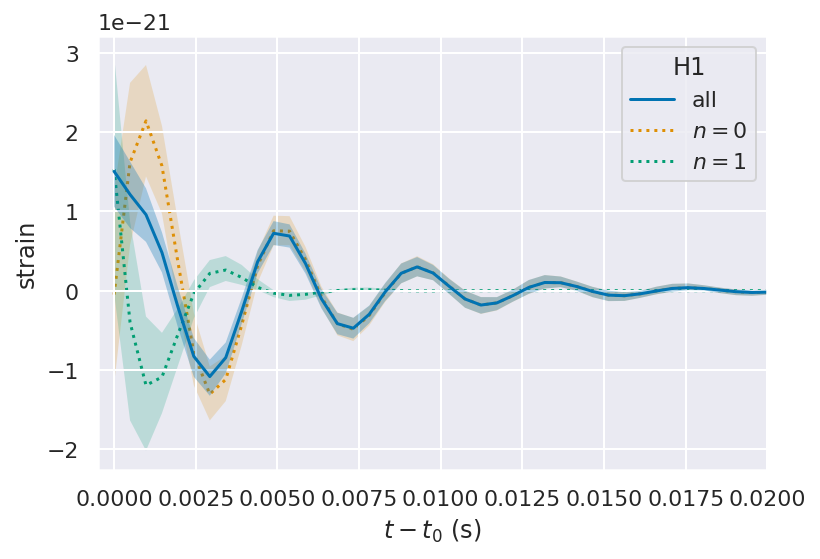

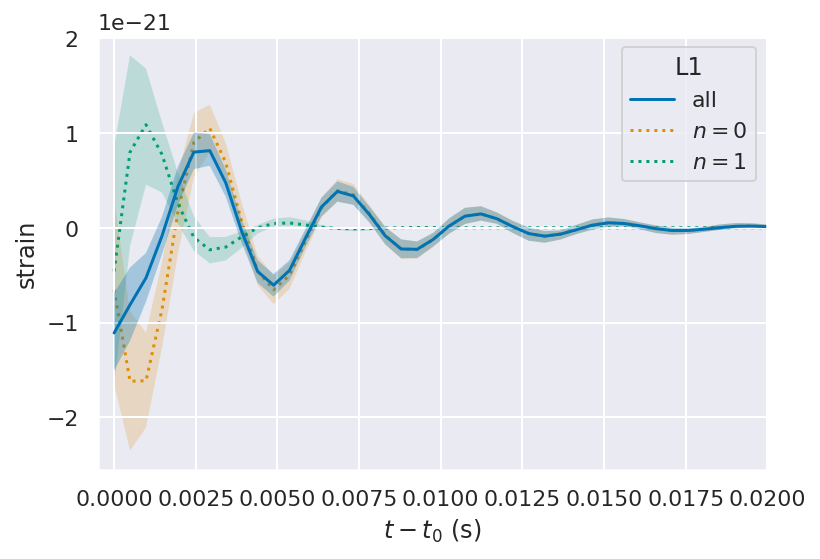

<Figure size 432x288 with 0 Axes>

In [22]:
# compute median and 90% CL for total reconstruction
hsamps = result.posterior.h_det
h = median(hsamps, axis=(0,1))
ys = [percentile(hsamps, p, axis=(0, 1)) for p in [5, 95]]

# compute median and 90% CL for individual modes
hsamps_mode = result.posterior.h_det_mode
h_mode = median(hsamps_mode, axis=(0,1))
ys_mode = [percentile(hsamps_mode, p, axis=(0, 1)) for p in [5, 95]]

# plot credible regions
for i, ifo in enumerate(ifos):
    t = fit.analysis_data[ifo].time
    l, = plot(t-t[0], h[i,:], label='all')
    fill_between(t-t[0], ys[0][i,:], ys[1][i,:], lw=0, 
                 color=l.get_color(), alpha=0.3)
    
    for n in range(fit.n_modes):
        l, = plot(t-t[0], h_mode[i,n,:], ls=':', label='$n=%i$' % n, zorder=-10)
        fill_between(t-t[0], ys_mode[0][i,n,:], ys_mode[1][i,n,:], lw=0, color=l.get_color(),
                     alpha=0.2, zorder=-10)
    xlim(-0.0005, 0.02);
    legend(title=ifo);
    xlabel('$t-t_0$ (s)');
    ylabel('strain')
    figure();

We may also plot the whitened residuals at each interferometer.

In [23]:
# whiten reconstructions
hwhites = []
for i, (ifo, acf) in enumerate(fit.acfs.items()):
    h = apply_along_axis(lambda x: acf.whiten(x), -1, hsamps[:,:,i,:])
    hwhites.append(h)

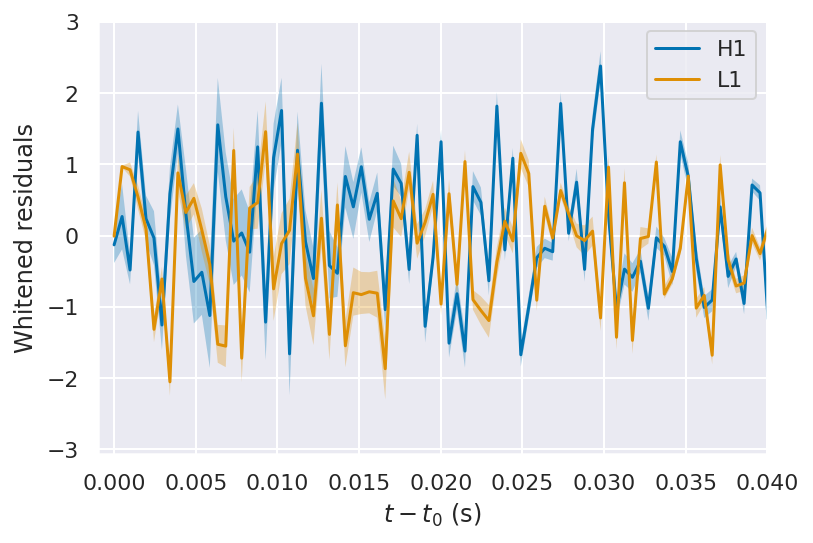

In [24]:
# compute credible regions for whitened reconstructions
h = median(hwhites, axis=(0,1))
ys = [percentile(hwhites, p, axis=(0, 1)) for p in [5, 95]]

# plot credible regions for whitened reconstructions
for i, ifo in enumerate(ifos):
    d = fit.acfs[ifo].whiten(fit.analysis_data[ifo])
    h = median(hwhites[i], axis=(0,1))
    ys = [percentile(hwhites[i], p, axis=(0, 1)) for p in [5, 95]]
    t = fit.analysis_data[ifo].time
    
    l, = plot(t-t[0], h-d, label=ifo)
    fill_between(t-t[0], ys[0]-d, ys[1]-d, lw=0, 
                 color=l.get_color(), alpha=0.3)

legend();
xlim(-0.001, 0.04);
xlabel('$t-t_0$ (s)')
ylabel('Whitened residuals');

Let's look at the recovered, matched-filter SNR in the network.

In [25]:
hsamps = result.posterior.h_det

snrs_ifos = []
for i, (ifo, acf) in enumerate(fit.acfs.items()):
    d = fit.analysis_data[ifo]
    snrs = apply_along_axis(lambda x: acf.compute_snr(x, d), -1, hsamps[:,:,i,:])
    snrs_ifos.append(snrs)

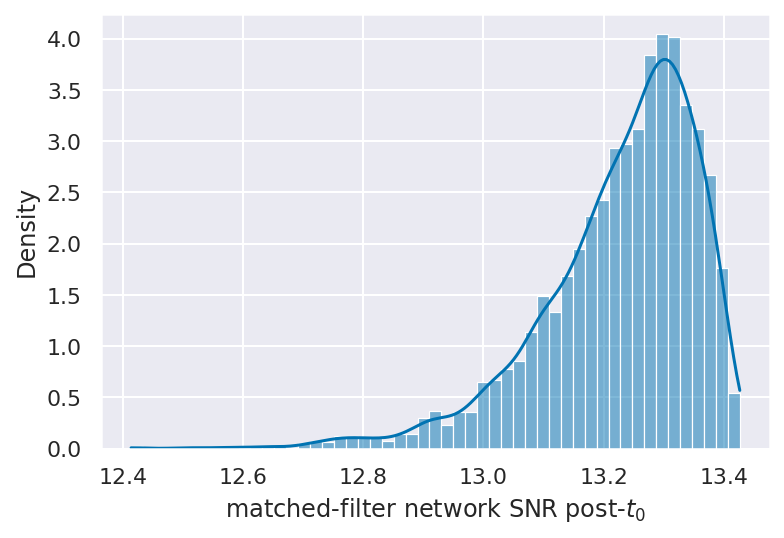

In [26]:
snrs_net = linalg.norm(snrs_ifos, axis=0)

sns.histplot(snrs_net.flatten(), stat='density', kde=True);
xlabel('matched-filter network SNR post-$t_0$');

In [30]:
result.constant_data.data_vars

Data variables:
    nsamp        (nsamp_dim_0) int64 410
    nmode        (nmode_dim_0) int64 2
    nobs         (nobs_dim_0) int64 2
    t0           (t0_dim_0) float64 1.126e+09 1.126e+09
    times        (times_dim_0, times_dim_1) float64 1.126e+09 ... 1.126e+09
    L            (L_dim_0, L_dim_1, L_dim_2) float64 1.751e-21 0.0 ... 3.284e-22
    FpFc         (FpFc_dim_0, FpFc_dim_1) float64 0.5787 -0.4509 -0.5274 0.2052
    dt_min       (dt_min_dim_0) float64 -1e-06
    dt_max       (dt_max_dim_0) float64 1e-06
    f_coeffs     (f_coeffs_dim_0, f_coeffs_dim_1) float64 -0.003905 ... 3.72e-05
    g_coeffs     (g_coeffs_dim_0, g_coeffs_dim_1) float64 -0.02097 ... -0.000...
    A_scale      (A_scale_dim_0) float64 5e-21
    drift_scale  (drift_scale_dim_0) float64 0.0
    perturb_f    (perturb_f_dim_0) float64 0.0 0.0
    perturb_tau  (perturb_tau_dim_0) float64 0.0 0.0
    df_max       (df_max_dim_0) float64 0.5
    dtau_max     (dtau_max_dim_0) float64 0.5
    M_min        (M_min_dim_

In [35]:
result.posterior.h_det

<xarray.DataArray 'h_det' (chain: 4, draw: 1000, h_det_dim_0: 2, h_det_dim_1: 410)>
array([[[[ 1.877315e-21, ...,  2.091365e-45],
         [-1.436485e-21, ..., -1.720894e-45]],

        ...,

        [[ 1.386707e-21, ..., -2.450204e-44],
         [-8.173335e-22, ...,  6.237703e-44]]],


       ...,


       [[[ 1.425284e-21, ...,  3.663081e-39],
         [-1.048728e-21, ..., -2.050627e-39]],

        ...,

        [[ 1.675093e-21, ...,  2.073820e-40],
         [-1.217593e-21, ..., -1.512726e-40]]]])
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * h_det_dim_0  (h_det_dim_0) int64 0 1
  * h_det_dim_1  (h_det_dim_1) int64 0 1 2 3 4 5 6 ... 404 405 406 407 408 409

# Analyze H1 data, whiten data, and best-matched ringdown waveform

In [72]:
fit.analysis_data['H1']

1.126259e+09    1.730158e-21
1.126259e+09    1.118345e-21
1.126259e+09    1.365295e-21
1.126259e+09   -2.013232e-22
1.126259e+09   -9.058060e-22
                    ...     
1.126259e+09    3.380087e-22
1.126259e+09    2.202615e-21
1.126259e+09    1.911297e-21
1.126259e+09    4.605021e-23
1.126259e+09    8.637838e-23
Length: 410, dtype: float64

In [69]:
type(fit.analysis_data['H1'])

ringdown.data.Data

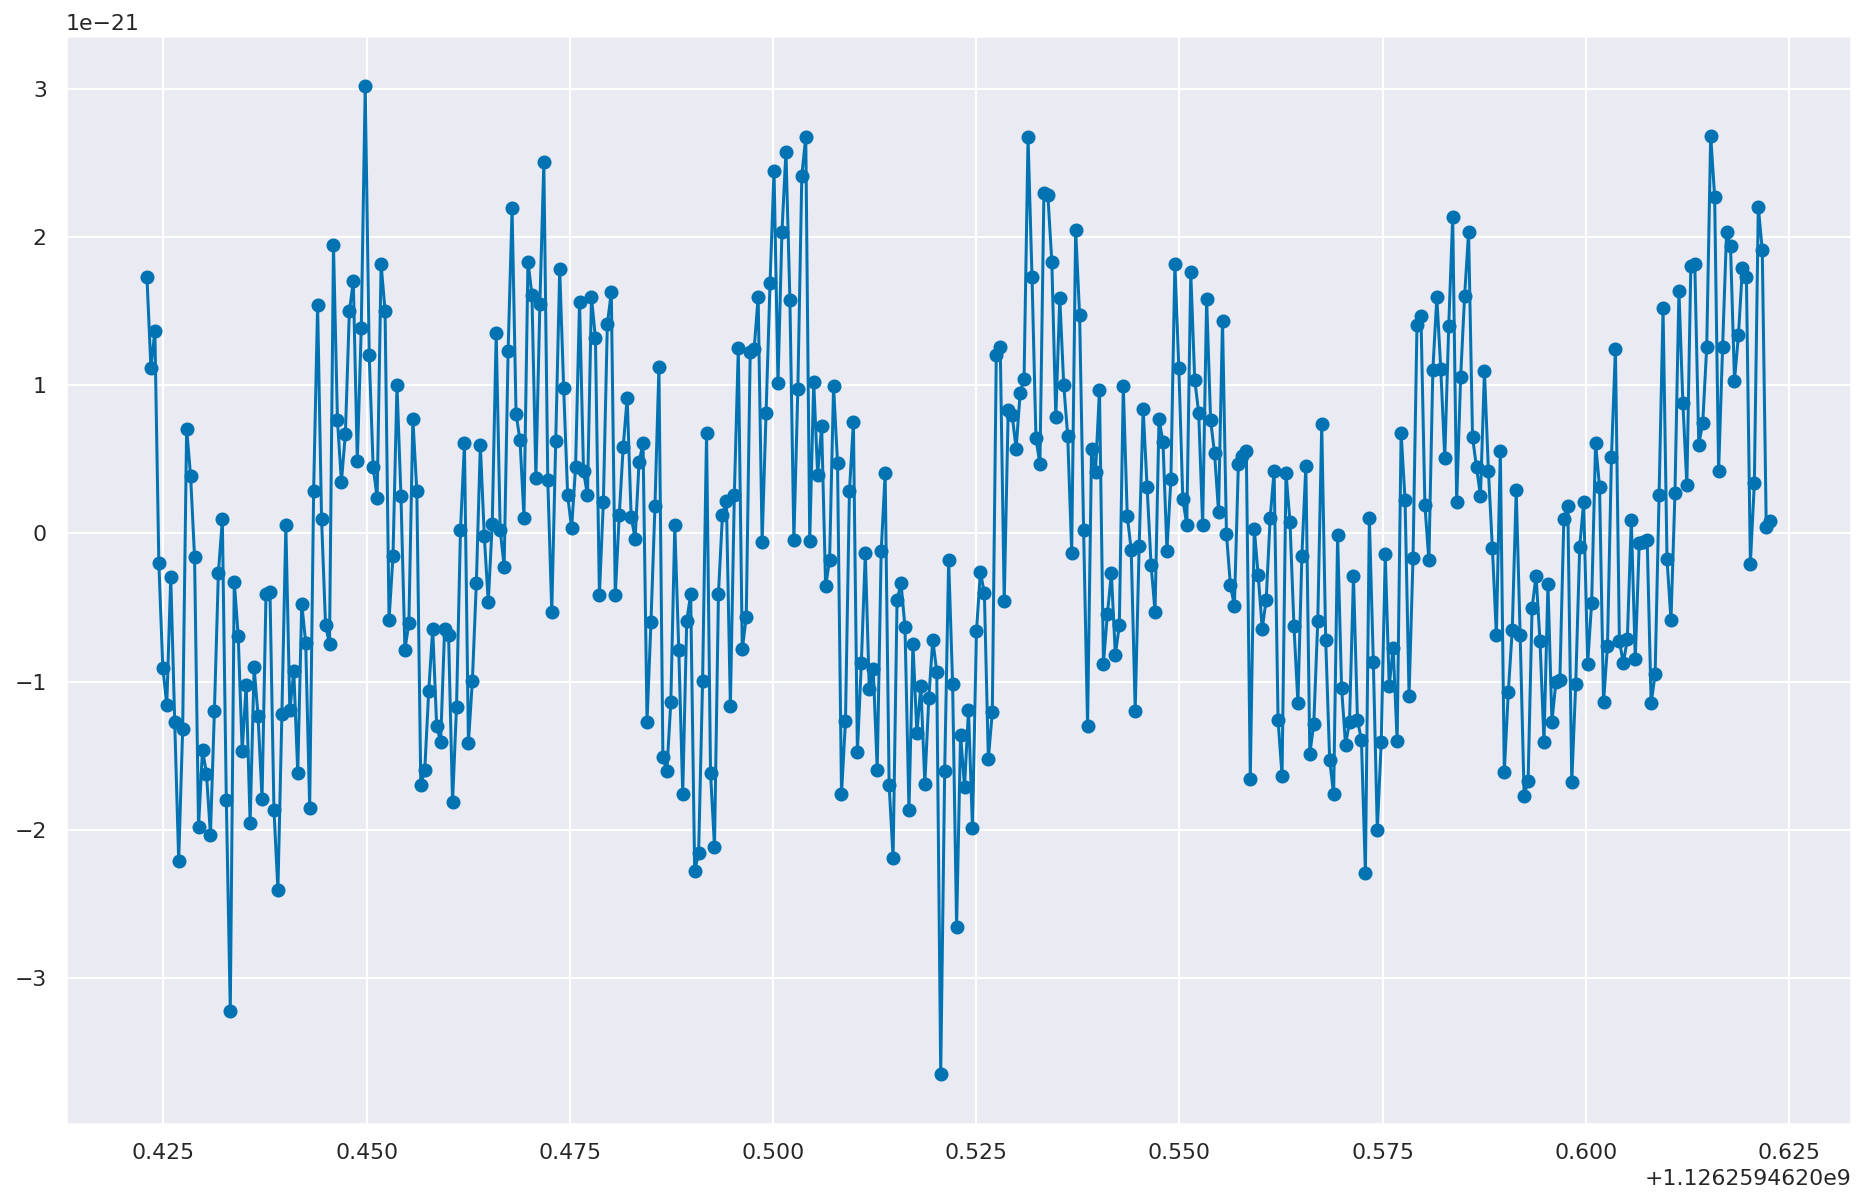

In [75]:
plt.figure(figsize=[16,10])
plt.plot(fit.analysis_data['H1'].time,fit.analysis_data['H1'],marker='o')

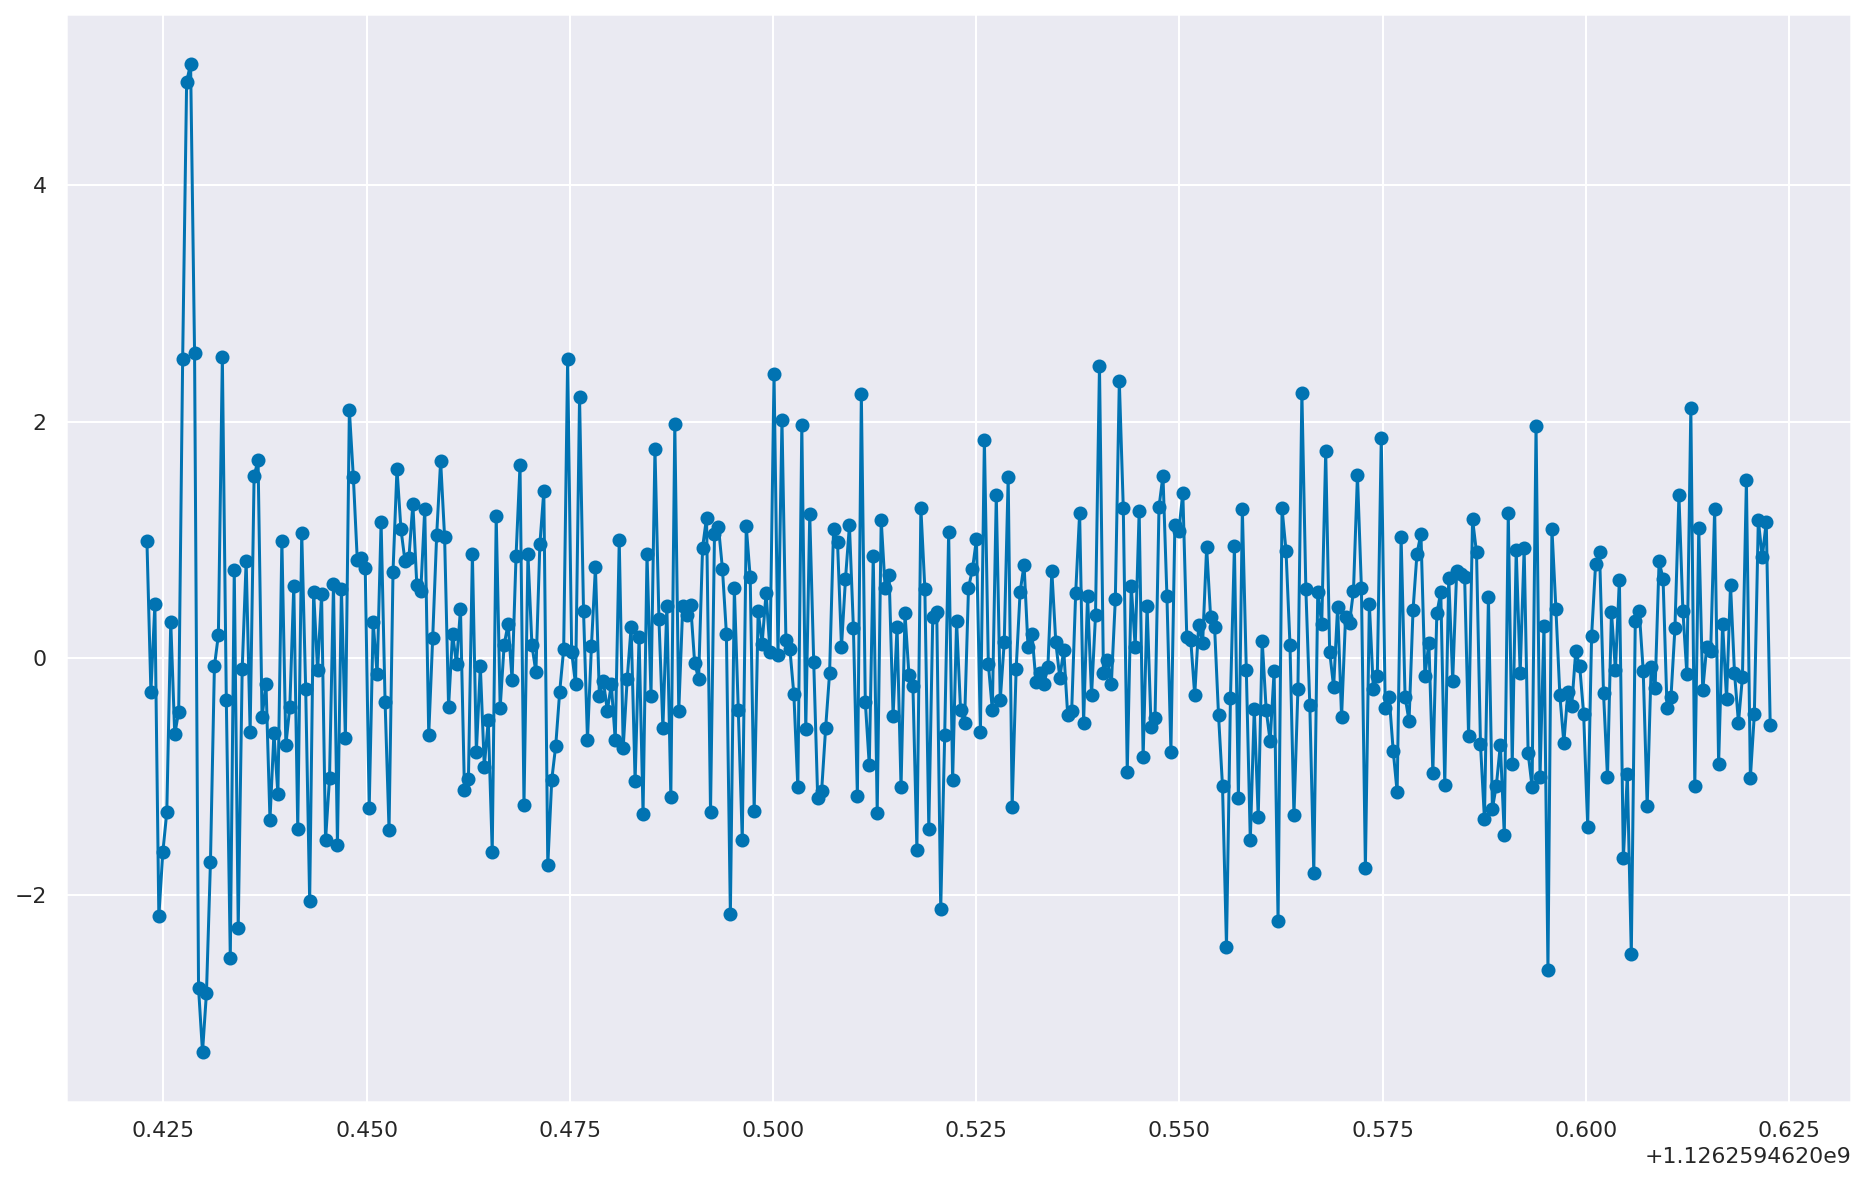

In [79]:
d = fit.acfs['H1'].whiten(fit.analysis_data['H1'])
plt.figure(figsize=[16,10])
plt.plot(d.time,d,marker='o')

In [80]:
hsamps = result.posterior.h_det

In [81]:
hsamps

<xarray.DataArray 'h_det' (chain: 4, draw: 1000, h_det_dim_0: 2, h_det_dim_1: 410)>
array([[[[ 1.877315e-21, ...,  2.091365e-45],
         [-1.436485e-21, ..., -1.720894e-45]],

        ...,

        [[ 1.386707e-21, ..., -2.450204e-44],
         [-8.173335e-22, ...,  6.237703e-44]]],


       ...,


       [[[ 1.425284e-21, ...,  3.663081e-39],
         [-1.048728e-21, ..., -2.050627e-39]],

        ...,

        [[ 1.675093e-21, ...,  2.073820e-40],
         [-1.217593e-21, ..., -1.512726e-40]]]])
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * h_det_dim_0  (h_det_dim_0) int64 0 1
  * h_det_dim_1  (h_det_dim_1) int64 0 1 2 3 4 5 6 ... 404 405 406 407 408 409

In [83]:
h = np.median(hsamps, axis=(0,1))

In [86]:
h.shape

(2, 410)

In [87]:
hsamps_mode = result.posterior.h_det_mode

In [88]:
hsamps_mode

<xarray.DataArray 'h_det_mode' (chain: 4, draw: 1000, h_det_mode_dim_0: 2, h_det_mode_dim_1: 2, h_det_mode_dim_2: 410)>
array([[[[[-1.089192e-22, ...,  2.091365e-45],
          [ 1.986234e-21, ..., -2.449775e-94]],

         [[-5.018117e-22, ..., -1.720894e-45],
          [-9.346737e-22, ...,  1.455939e-94]]],


        ...,


        [[[ 2.064952e-22, ..., -2.450204e-44],
          [ 1.180212e-21, ..., -8.252345e-89]],

         [[-8.120246e-22, ...,  6.237703e-44],
          [-5.308948e-24, ...,  1.097680e-88]]]],



       ...,



       [[[[-4.783978e-22, ...,  3.663081e-39],
          [ 1.903681e-21, ...,  2.512957e-75]],

         [[-2.368710e-22, ..., -2.050627e-39],
          [-8.118568e-22, ..., -3.998962e-75]]],


        ...,


        [[[-5.836278e-22, ...,  2.073820e-40],
          [ 2.258721e-21, ..., -4.343209e-79]],

         [[-3.398530e-22, ..., -1.512726e-40],
          [-8.777403e-22, ...,  3.096003e-79]]]]])
Coordinates:
  * chain             (chain) int64 0 1 2 3
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * h_det_mode_dim_0  (h_det_mode_dim_0) int64 0 1
  * h_det_mode_dim_1  (h_det_mode_dim_1) int64 0 1
  * h_det_mode_dim_2  (h_det_mode_dim_2) int64 0 1 2 3 4 ... 405 406 407 408 409

In [89]:
h_mode = median(hsamps_mode, axis=(0,1))

In [90]:
h_mode

array([[[-4.92974123e-023,  1.61851829e-021,  2.14140241e-021, ...,
         -5.87147410e-050,  2.32081432e-050, -4.95051261e-049],
        [ 1.53143974e-021, -3.99931910e-022, -1.19308666e-021, ...,
          2.85650580e-105,  7.73235719e-103,  1.41062424e-106]],

       [[-6.53223646e-022, -1.61836881e-021, -1.61284715e-021, ...,
          4.13416658e-050, -1.83436260e-052,  5.08462637e-049],
        [-4.59577568e-022,  7.97999170e-022,  1.08662306e-021, ...,
         -5.11044413e-108, -9.07639153e-105, -1.19786629e-109]]])

In [99]:
fit.acfs

{'H1': 0.000000    3.065707e-42
 0.000488    2.495036e-42
 0.000977    2.017488e-42
 0.001465    2.238325e-42
 0.001953    2.557994e-42
                 ...     
 0.997559    2.193728e-42
 0.998047    2.557994e-42
 0.998535    2.238325e-42
 0.999023    2.017488e-42
 0.999512    2.495036e-42
 Length: 2048, dtype: float64,
 'L1': 0.000000    9.206336e-40
 0.000488    3.862256e-42
 0.000977   -9.049181e-40
 0.001465    1.879704e-41
 0.001953    9.185249e-40
                 ...     
 0.997559   -1.197268e-41
 0.998047    9.185249e-40
 0.998535    1.879704e-41
 0.999023   -9.049181e-40
 0.999512    3.862256e-42
 Length: 2048, dtype: float64}

In [98]:
fit.acfs.items()

dict_items([('H1', 0.000000    3.065707e-42
0.000488    2.495036e-42
0.000977    2.017488e-42
0.001465    2.238325e-42
0.001953    2.557994e-42
                ...     
0.997559    2.193728e-42
0.998047    2.557994e-42
0.998535    2.238325e-42
0.999023    2.017488e-42
0.999512    2.495036e-42
Length: 2048, dtype: float64), ('L1', 0.000000    9.206336e-40
0.000488    3.862256e-42
0.000977   -9.049181e-40
0.001465    1.879704e-41
0.001953    9.185249e-40
                ...     
0.997559   -1.197268e-41
0.998047    9.185249e-40
0.998535    1.879704e-41
0.999023   -9.049181e-40
0.999512    3.862256e-42
Length: 2048, dtype: float64)])

In [102]:
hsamps

<xarray.DataArray 'h_det' (chain: 4, draw: 1000, h_det_dim_0: 2, h_det_dim_1: 410)>
array([[[[ 1.877315e-21, ...,  2.091365e-45],
         [-1.436485e-21, ..., -1.720894e-45]],

        ...,

        [[ 1.386707e-21, ..., -2.450204e-44],
         [-8.173335e-22, ...,  6.237703e-44]]],


       ...,


       [[[ 1.425284e-21, ...,  3.663081e-39],
         [-1.048728e-21, ..., -2.050627e-39]],

        ...,

        [[ 1.675093e-21, ...,  2.073820e-40],
         [-1.217593e-21, ..., -1.512726e-40]]]])
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * h_det_dim_0  (h_det_dim_0) int64 0 1
  * h_det_dim_1  (h_det_dim_1) int64 0 1 2 3 4 5 6 ... 404 405 406 407 408 409

In [104]:
# whiten reconstructions
hwhites = []
for i, (ifo, acf) in enumerate(fit.acfs.items()):
    print(i)
    h = apply_along_axis(lambda x: acf.whiten(x), -1, hsamps[:,:,i,:])
    hwhites.append(h)

0
1


In [106]:
dwhite = fit.acfs['H1'].whiten(fit.analysis_data['H1'])
hmedianwhite = median(hwhites[0], axis=(0,1))

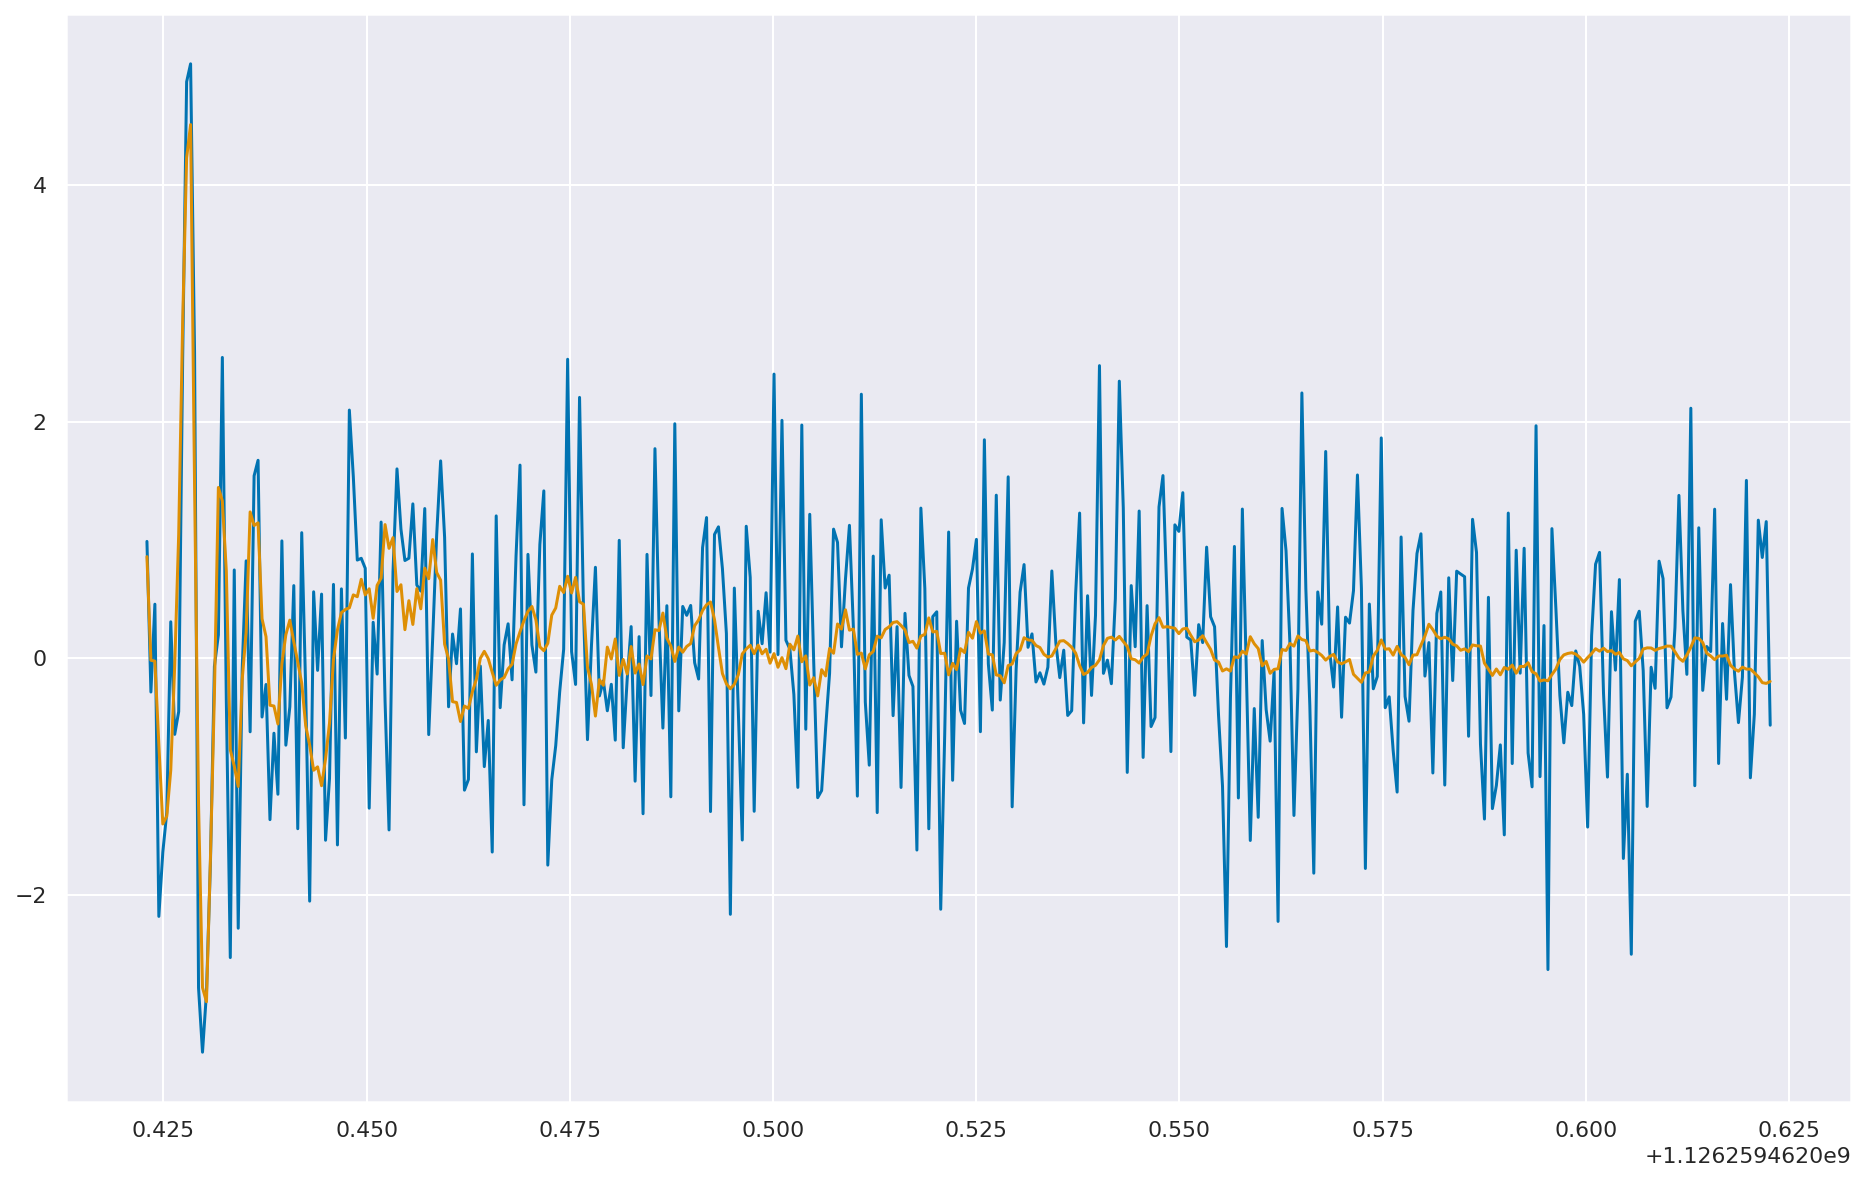

In [109]:
plt.figure(figsize=[16,10])
plt.plot(d.time,dwhite)
plt.plot(d.time,hmedianwhite)